In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


In [2]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)


In [4]:
# 使用张量来初始化隐藏状态
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [5]:
# 通过一个隐藏状态和一个输入，我们就可以用更新后的隐藏状态计算输出
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
# Y：（时间，batch_size，输出）
Y.shape, state_new.shape


(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [6]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""

    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            # Pytorch RNN实现中不包含输出层
            # 因此需要自己添加一个输出层
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                               device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                torch.zeros((
                    self.num_directions * self.rnn.num_layers,
                    batch_size, self.num_hiddens), device=device))


In [7]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)


'time travellerdddddddddd'

perplexity 1.3, 203590.4 tokens/sec on cuda:0
time travellerio s afallow the erust yfice if filway y the plane
traveller hal of the trementime sperlared frave it th pe he


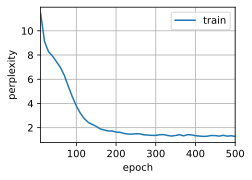

In [8]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)
